In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
random.seed(10)

In [2]:
center_x = 0
center_y = 0
center_z = 0

radius  = 5000

print("Total area is = " + str(radius*radius*math.pi))

Total area is = 78539816.33974482


In [3]:
class FSS_Channels:
  # channels start at 0, so a channel plan with 8 channels is from 0 to 7

  band_width = 240e6 # 240MHz

  # 10.7-12.7 GHz frequency range
  range_start = 10.7e9 # 10.7GHz
  range_end = 12.7e9 # 12.7GHz

  channel_count = 8

  range_size = range_end - range_start
  unused_space = range_size - band_width * channel_count

  # FSS channel spacing should be 10MHz
  space_between_channels = unused_space / channel_count

  @staticmethod
  def getChannelRange(channel) -> Tuple[int, int]:
    channel_start = int((0.5 + channel) * FSS_Channels.space_between_channels + channel * FSS_Channels.band_width)
    channel_end = channel_start + FSS_Channels.band_width
    return channel_start, channel_end

  def __init__(channel):
    self.channel = channel

In [4]:
class BS_Channels:
  # channels start at 1, so a channel plan with 5 channels is from 1 to 5

  band_width = 100e6 # 100MHz

  # 12.2-12.7 GHz frequency range
  range_start = 12.2e9 # 12.2GHz
  range_end = 12.7e9 # 12.7GHz

  channel_count = 5

  range_size = range_end - range_start
  unused_space = range_size - band_width * channel_count

  # BS channel spacing should be 0MHz
  space_between_channels = unused_space / channel_count

  @staticmethod
  def getChannelRange(channel) -> Tuple[int, int]:
    channel -= 1
    
    channel_start = int((0.5 + channel) * BS_Channels.space_between_channels + channel * BS_Channels.band_width)
    channel_end = channel_start + BS_Channels.band_width
    return channel_start, channel_end

  def __init__(channel):
    self.channel = channel

In [5]:
class BS:
  def __init__(self, radius, max_height, carr_freq, interference_type):
    self.radius = radius
    self.max_height = max_height
    self.carr_freq = carr_freq
    self.interference_type = interference_type
    self.base_heights = {
        'UMi': 10,
        'UMa': 25,
        'RMa': 35,
        None: random.randint(10, 35)
    }
    self.BS_x = random.randint(-4000,4000) + 1000*random.random()
    self.BS_y = random.randint(-4000,4000) + 1000*random.random()
    self.BS_z = self.base_heights[self.interference_type]

  def BS_random_co_ordinates(self):
    return self.BS_x, self.BS_y, self.BS_z
 
  def UE_random_co_ordinates(self):
    UE_x = random.randint(-4000,4000) + 1000*random.random()
    UE_y = random.randint(-4000,4000) + 1000*random.random()
    UE_z = random.uniform(0,1.5)
    
    return UE_x, UE_y, UE_z

# Creating the FSS class
  def FSS_random_co_ordinates(self):

    FSS_x = random.randint(-4000,4000) + 1000*random.random()
    FSS_y = random.randint(-4000,4000) + 1000*random.random()
    FSS_z = random.choice([1.5,4.5])
    
    return FSS_x, FSS_y, FSS_z


In [6]:
def path_loss_UMi(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z):
##UMi
##LOS,SF=4:

##(10m<=d_2D)<=D_BP:
    h=5
    d_2D=math.sqrt(((FSS_X-BS_X)**2)+((FSS_Y-BS_Y)**2)+((FSS_Z-BS_Z)**2))
    hBs=10
    fc=12e3
    d_3D=math.sqrt(hBs**2+d_2D**2)
    PL1umi=32.4+21*math.log10 (d_3D)+20*math.log10(fc)
    
##(D_BP<=d_2D)<=5000m:
    hBs=10
    hUT=1.5
    hE=1
    hBs1=hBs-hE
    hUT1=hUT-hE
    c=3*10**8
    D_BP= (4*hBs1*hUT1*fc)/c
    PL2umi=32.4+40*math.log10(d_3D)+20*math.log10(fc)-9.5*math.log10((D_BP)**2+(hBs-hUT)**2)
    
    if 10 <=d_2D and d_2D<=D_BP:
        PLUMiLOS=PL1umi
    elif D_BP<=d_2D and  d_2D<=5000:
        PLUMiLOS= PL2umi  
    else:
        PLUMiLOS=1

##NLOS,SF=7.82:
    PL1umiNLOS= 35.3*math.log10(d_3D)+22.4+21.3*math.log10(fc)-0.3*(hUT-1.5)
    PLUMiNLOS= max(PL2umi,PL1umiNLOS)
    
##Loss Probability:
    if d_2D>18:
        PrLosUmi=(18/d_2D)+math.exp((-(d_2D/36))*(1-(18/d_2D)))     
    else:
        PrLosUmi=1 ##d_2d<=18   
    
    if PrLosUmi > random.random():
        path_loss_UMi = PLUMiLOS
    
    else:
        path_loss_UMi = PLUMiNLOS
    
##path_loss 
#     path_loss_UMi= PL2umi*PrLosUmi+PL1umiNLOS*(1-PrLosUmi)
    
    return path_loss_UMi,d_2D

In [7]:
def path_loss_UMa(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z):
##LOS,SF=4:
##(10m<=d_2D)<=D_BP:
    fc=12e3
    h=5
    d_2D=math.sqrt(((FSS_X-BS_X)**2)+(FSS_Y- BS_Y)**2)+((FSS_Z-BS_Z)**2)
    hBs=25
    d_3D=math.sqrt(hBs**2+d_2D**2)
    PL3uma=28.0+22*math.log10(d_3D)+20*math.log10(fc)
    
##(D_BP<=d_2D) <=5000m:
    hUT=1.5
    hE=1
    hBs1=hBs-hE
    hUT1=hUT-hE
    c=3*10**8
    D_BP= (4*hBs1*hUT1*fc)/c
    PL4uma=28.0+40*math.log10(d_3D)+20*math.log10(fc)-9*math.log10((D_BP)**2+(hBs-hUT)**2)
    
    if 10 <=d_2D and d_2D<=D_BP:
        PLUMALOS=PL3uma
    elif D_BP<=d_2D and d_2D<=5000:
        PLUMALOS= PL4uma  
    else:
        PLUMALOS=1
        
##NLOS,SF=6:
    PL1NLOSuma=13.54+39.08*math.log10(d_3D)+20*math.log10(fc)-0.6*(hUT-1.5)
    PLUMANLOS=max(PL4uma,PL1NLOSuma)

##NLOS,SF=7.8 (optional)
##PL_Optional=32.4+20*math.log(fc)+30*math.log(d_3D)

##Loss Probability:
    if d_2D >18:
        if hUT<=13:
            ChUT=0
        elif 13<hUT and hUT<=23:
            ChUT=((hUT-13)/10)**1.5  
        PrLOSUma=((18/d_2D)+math.exp((-(d_2D/63))*(1-(18/d_2D))))*(1+ChUT*(5/4)*((d_2D/100)**3)*math.exp(-(d_2D/150)))
    else:##18m<d_2D:
        PrLOSUma=1
        
    if PrLOSUma > random.random():
        path_loss_UMa = PLUMALOS
    
    else:
        path_loss_UMa = PLUMANLOS
    
##Path Loss
#     path_loss_UMa= PL4uma*PrLOSUma+PL1NLOSuma*(1-PrLOSUma)
    return path_loss_UMa, d_2D

In [8]:
def path_loss_RMa(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z):
##LOS,SF=4(PL1),SF=6(PL2)
##10m<=d_2D<=d_BP: 
    fc=12e3
    h=5
    d_2D=math.sqrt(((FSS_X-BS_X)**2)+((FSS_Y- BS_Y)**2)+((FSS_Z-BS_Z)**2))
    hBs=35
    d_3D= math.sqrt(hBs**2+d_2D**2)
    PL1rma=20*math.log10((40*math.pi*d_3D*fc)/3)+ min(0.03*h**1.72,10)*math.log10(d_3D)-min(0.044*h**1.72,14.77)+0.002*math.log10(h)*d_3D
    
##d_BP<=d_2D<=10km:
    hUT=1.5
    c=3*10**8
    d_BP= (2*math.pi*hBs*hUT*fc)/c
    PL2rma= PL1rma*(d_BP)+40*math.log10(d_3D/d_BP)

    if 10<=d_2D and d_2D <=d_BP:
        PLRMALOS=PL1rma
    elif d_BP<=d_2D and d_2D <=10000:
        PLRMALOS= PL2rma  
    else:
        PLRMALOS=1

##NLOS,SF=8:
    W=20
    h=5
    PL1NLOSrma= 161.04-7.11*math.log10(W)+7.5*math.log10(h)-(24.37-3.7*(h/hBs)**2)*math.log10(hBs)+(43.42-3.1*math.log10(hBs))*(math.log10(d_3D)-3)+20*math.log10(fc)-(3.2*(math.log10(11.75*hUT))**2-4.97)
    PLRMANLOS=max(PL2rma,PL1NLOSrma)

##Loss Probability:
    if d_2D>10:
        PrLOSrma=math.exp(-((d_2D-10)/1000))
        
## 10m<d_2D:
    else:
        PrLOSrma=1
        
    if PrLOSrma > random.random():
        path_loss_RMa= PLRMALOS
    
    else:
        path_loss_RMa = PLRMANLOS

##PathLoss:
#     path_loss_RMa=PL2rma*PrLOSrma+PL1NLOSrma*(1-PrLOSrma)
    return path_loss_RMa, d_2D

In [9]:
def Interface_UMi_1(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z,FSS_phi,pathloss_UMi,theta_tilt,phi_scan,output=False):
        LBodyLoss=4
#         LSpectralOverlap=10*math.log(10)
        # theta_tilt, phi_scan = max_gain_5g_parameters(theta, phi)
        x, y, z = BS_X-FSS_X, BS_Y-FSS_Y, BS_Z-FSS_Z

        theta_bs_es = math.degrees(math.atan(y/x)) % 360
        phi_bs_es = math.degrees(math.sqrt(x**2 + y**2) / z) % 360
        fss_phi_difference = abs(FSS_phi - phi_bs_es)
        if output: print("theta_bs_es:", theta_bs_es, "phi_bs_es:", phi_bs_es)

        G_5G_R=gain_5g(theta_bs_es, phi_bs_es, theta_tilt, phi_scan)
        G_Rx_5G=gain_fss_wbes_b(fss_phi_difference)

        TXPower=41.3
#         LBuildingLoss=1
        interface1=TXPower+ G_5G_R-pathloss_UMi- LBodyLoss + G_Rx_5G
        return interface1,pathloss_UMi

In [10]:
def Interface_UMa_1(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z,FSS_phi,pathloss_UMa,theta_tilt,phi_scan,output=False):
        LBodyLoss=4
#         LSpectralOverlap=10*math.log(10)
        x, y, z = BS_X-FSS_X, BS_Y-FSS_Y, BS_Z-FSS_Z

        theta_bs_es = math.degrees(math.atan(y/x)) % 360
        phi_bs_es = math.degrees(math.sqrt(x**2 + y**2) / z) % 360
        fss_phi_difference = abs(FSS_phi - phi_bs_es)
        # if output: print("theta_bs_es:", theta_bs_es, "phi_bs_es:", phi_bs_es)

        G_5G_R=gain_5g(theta_bs_es, phi_bs_es, theta_tilt, phi_scan)
        G_Rx_5G=gain_fss_wbes_b(fss_phi_difference)
        
        TXPower=41.3
#         LBuildingLoss=1
        interface2=TXPower+ G_5G_R-pathloss_UMa- LBodyLoss + G_Rx_5G
        return interface2,pathloss_UMa

In [11]:
def Interface_RMa_1(BS_X,BS_Y,BS_Z,FSS_X,FSS_Y,FSS_Z,FSS_phi,pathloss_RMa,theta_tilt,phi_scan,output=False):
        LBodyLoss=4
#         LSpectralOverlap=10*math.log(10)
        x, y, z = BS_X-FSS_X, BS_Y-FSS_Y, BS_Z-FSS_Z

        theta_bs_es = math.degrees(math.atan(y/x)) % 360
        phi_bs_es = math.degrees(math.sqrt(x**2 + y**2) / z) % 360
        # if output: print("theta_bs_es:", theta_bs_es, "phi_bs_es:", phi_bs_es)
        fss_phi_difference = abs(FSS_phi - phi_bs_es)
        if output: print("fss_phi_difference:", fss_phi_difference)

        G_5G_R=gain_5g(theta_bs_es, phi_bs_es, theta_tilt, phi_scan)
        G_Rx_5G=gain_fss_wbes_b(fss_phi_difference)
        
        TXPower=41.3
#         LBuildingLoss=1
        interface3=TXPower+ G_5G_R-pathloss_RMa-LBodyLoss + G_Rx_5G
        return interface3,pathloss_RMa

In [12]:
k = 1.38064852*10**(-23)
T=200
B=240e6
Noise = 10*math.log10(k*T*B)
Noise_W = 10 ** (Noise / 10)
print('Noise:', Noise)
print('Noise in Watts:', Noise_W)

Noise: -121.78675630934148
Noise in Watts: 6.627112895999999e-13


In [13]:
bs_ue_max_radius = 1000

fss1 = BS(radius, max_height=1.5, carr_freq=12e3, interference_type=None)
x,y,z = fss1.FSS_random_co_ordinates()
        
def simulate(output=True):
    FSS_X=np.array([])
    FSS_Y=np.array([])
    FSS_Z=np.array([])
    FSS_CHANNELS = []
    for i in range (1):
        FSS_X = np.append(FSS_X, x)
        FSS_Y = np.append(FSS_Y, y)
        FSS_Z = np.append(FSS_Z, z)
        # 0 means not in use, 1 means in use
        channel_status = [random.randint(0, 1) for i in range(FSS_Channels.channel_count)]
        channels_used = np.array([i for i in range(FSS_Channels.channel_count) if channel_status[i] == 1])
        FSS_CHANNELS.append(channels_used)
        if output: print("FSS Co-ordinates=" +str (x)+ "," + str(y)+ "," + str(z) + ", channel: " + str(channels_used))
    if output: print(FSS_X, FSS_Y, FSS_Z, FSS_CHANNELS)

    # Create base stations
    BS_X=np.array([])
    BS_Y=np.array([])
    BS_Z=np.array([])
    for i in range (1):
        bs1 = BS(radius, max_height=35, carr_freq=12e3, interference_type=None)
        x2,y2,z2 = bs1.BS_random_co_ordinates()
        BS_X = np.append(BS_X, x2)
        BS_Y = np.append(BS_Y, y2)
        BS_Z = np.append(BS_Z, z2)
        if output: print("Bs Co-ordinates=" +str (x2)+ "," + str(y2)+ "," + str(z2))
    
    if output: print(BS_X,BS_Y,BS_Z)

    # Create user equipment
    UE_X=np.array([])
    UE_Y=np.array([])
    UE_Z=np.array([])
    UE_CHANNEL=np.array([])
    for i in range(3):
    # number of split regions
    # i is the sector number
      for j in range(10):
      # number of UEs per region
      # j is the number of the UE in one sector
        bs_x, bs_y, bs_z = BS_X[-1], BS_Y[-1], BS_Z[-1]
        theta_bs_ue = random.uniform(120 * i, 120 * (i+1))
        # 0-120, 120-240, 240-360
        radius_bs_ue = random.uniform(0, bs_ue_max_radius)

        x1 = radius_bs_ue * math.cos(math.radians(theta_bs_ue))
        y1 = radius_bs_ue * math.sin(math.radians(theta_bs_ue))

        UE_X = np.append(UE_X, x1)
        UE_Y = np.append(UE_Y, y1)
        UE_Z = np.append(UE_Z, 1.5)
        
        maximum_UEs_per_channel = 4

        if j > maximum_UEs_per_channel * BS_Channels.channel_count:
          raise Exception(f"BS cannot support {j} UEs")

        count = {i: 0 for i in range(1, BS_Channels.channel_count + 1)}

        channel = random.randint(1, BS_Channels.channel_count)

        while count[channel] >= maximum_UEs_per_channel:
          channel = random.randint(1, BS_Channels.channel_count)

        count[channel] += 1

        UE_CHANNEL = np.append(UE_CHANNEL, channel)

        if output: print("UE Co-ordinates=" +str (x1)+ "," + str(y1)+ "," + str(z1) + ", channel: " + str(channel))
    if output: print(UE_X,UE_Y,UE_Z)
        
    pathloss_UMa=np.empty([0])
    pathloss_UMi=np.empty([0])
    pathloss_RMa=np.empty([0])
    distance_UMa=np.empty([0])
    distance_UMi=np.empty([0])
    distance_RMa=np.empty([0])  
    for i in range(len(BS_X)):
        for j in range (len(FSS_X)):
            pathlossumi,distance= path_loss_UMi(BS_X[i],BS_Y[i],10,FSS_X[j],FSS_Y[j],FSS_Z[j])
            pathlossuma,distance= path_loss_UMa(BS_X[i],BS_Y[i],25,FSS_X[j],FSS_Y[j],FSS_Z[j])
            pathlossrma,distance= path_loss_RMa(BS_X[i],BS_Y[i],35,FSS_X[j],FSS_Y[j],FSS_Z[j])
            if output: print("pathloss umi:", pathlossumi, "uma:", pathlossuma, "rma:", pathlossrma, "for distance", distance)
            pathloss_UMa=np.append(pathloss_UMa,pathlossuma)
            distance_UMa=np.append(distance_UMa,distance)
            pathloss_UMi=np.append(pathloss_UMi,pathlossumi)
            distance_UMi=np.append(distance_UMi,distance)
            pathloss_RMa=np.append(pathloss_RMa,pathlossrma)
            distance_RMa=np.append(distance_RMa,distance)
            

    if output: print(pathloss_UMi,distance_UMi)
    if output: print(pathloss_UMa,distance_UMa)
    if output: print(pathloss_RMa,distance_RMa)

    interface_UMi=np.empty([0])
    interface_UMa=np.empty([0])
    interface_RMa=np.empty([0])
    for i in range(len(BS_X)):
        for j in range(len(FSS_X)):
            for k in range(len(UE_X)):
                # channel check
                # if UE is using channel 1, the start is 12.2GHz and the end is 12.3GHz
                bs_channel_start, bs_channel_end = BS_Channels.getChannelRange(UE_CHANNEL[k])
                bs_channel_range = range(bs_channel_start, int(bs_channel_end + (5e6)), int(5e6))

                interference_found = False

                for fss_channel in FSS_CHANNELS[j]:
                    # if fss_channel >= 6:
                    fss_channel_start, fss_channel_end = FSS_Channels.getChannelRange(fss_channel)
                    fss_channel_range = range(bs_channel_start, int(bs_channel_end + (5e6)), int(5e6))
                    
                    bs_set = set(bs_channel_range)
                    if len(bs_set.intersection(fss_channel_range)):
                        interference_found = True

                if not interference_found:
                    interface_UMi=np.append(interface_UMi,0)
                    interface_UMa=np.append(interface_UMa,0)
                    interface_RMa=np.append(interface_RMa,0)
                    continue

                for interference_type in ["UMi", "UMa", "RMa"]:
                    if interference_type == "UMi":
                        BS_Z = np.array([10 for i in range(len(BS_X))])
                    elif interference_type == "UMa":
                        BS_Z = np.array([25 for i in range(len(BS_X))])
                    elif interference_type == "RMa":
                        BS_Z = np.array([35 for i in range(len(BS_X))])
                    # bs_ue_x, bs_ue_y, bs_ue_z = BS_X-UE_X, BS_Y-UE_Y, BS_Z-UE_Z
                    bs_ue_x, bs_ue_y, bs_ue_z = UE_X[k]-BS_X[i], UE_Y[k]-BS_Y[i], UE_Z[k]-BS_Z[i]

                    theta_bs_ue = np.arctan(bs_ue_y/bs_ue_x)
                    phi_bs_ue = np.sqrt(bs_ue_x**2 + bs_ue_y**2) / bs_ue_z

                    theta_bs_ue = np.degrees(theta_bs_ue) % 360
                    phi_bs_ue = np.degrees(phi_bs_ue) % 360
                    if output: print("theta_bs_ue:", theta_bs_ue, "phi_bs_ue:", phi_bs_ue)

                    theta_tilt, phi_scan = max_gain_5g_parameters(theta_bs_ue, phi_bs_ue)

                    if interference_type == "UMi":
                        interfaceumi,pathloss_UMi_x= Interface_UMi_1(BS_X[i],BS_Y[i],BS_Z[i],FSS_X[j],FSS_Y[j],FSS_Z[j],15,pathloss_UMi[i*len(FSS_X)+j],theta_tilt,phi_scan)
                        if output: print("interference umi:", interfaceumi, "pathloss:", pathlossuma)
                        interface_UMi=np.append(interface_UMi,interfaceumi)
                    elif interference_type == "UMa":
                        interfaceuma,pathloss_UMa_x= Interface_UMa_1(BS_X[i],BS_Y[i],BS_Z[i],FSS_X[j],FSS_Y[j],FSS_Z[j],48,pathloss_UMa[i*len(FSS_X)+j],theta_tilt,phi_scan)
                        if output: print("interference umi:", interfaceuma, "pathloss:", pathlossuma)
                        interface_UMa=np.append(interface_UMa,interfaceuma)
                    elif interference_type == "RMa":
                        interfacerma,pathloss_RMa_x= Interface_RMa_1(BS_X[i],BS_Y[i],BS_Z[i],FSS_X[j],FSS_Y[j],FSS_Z[j],5,pathloss_RMa[i*len(FSS_X)+j],theta_tilt,phi_scan)
                        if output: print("interference umi:", interfacerma, "pathloss:", pathlossuma)
                        interface_RMa=np.append(interface_RMa,interfacerma)
                    
    interface_UMi_W = np.sum(10 ** (interface_UMi / 10))
    interface_UMa_W = np.sum(10 ** (interface_UMa / 10))
    interface_RMa_W = np.sum(10 ** (interface_RMa / 10))
              
    if output: print(interface_UMi,pathloss1Umi)
    if output: print(interface_UMa,pathloss1UMa)
    if output: print(interface_RMa,pathloss1RMa)

    # I_N_UMi = np.array([interfaceumi-Noise for interfaceumi in interface_UMi])
    I_N_UMi = interface_UMi_W / Noise_W
    if output: print('I/N UMi:', I_N_UMi)
    I_N_UMa = interface_UMa_W / Noise_W
    if output: print('I/N UMa:', I_N_UMa)      
    I_N_RMa = interface_RMa_W / Noise_W
    if output: print('I/N RMa:', I_N_RMa)  

    return distance_RMa, I_N_RMa, distance_UMa, I_N_UMa, distance_UMi, I_N_UMi
        

In [14]:
# Prototype functions to calculate antenna gain of 5G base station and FSS earth station

import math, cmath
from scipy import optimize

# gain is in dBi

# 3GPP TR 38.901
# https://www.etsi.org/deliver/etsi_tr/138900_138999/138901/14.00.00_60/tr_138901v140000p.pdf
antenna_gain_max = 8

# values recommended by Dr. Zoheb
rows = 16  # Nv
cols = 16  # Nh
hspace = 0.5  # dh/λ
vspace = 0.5  # dv/λ

# constant values based on ECC Rep 281
phi_3db = 80  # degrees
theta_3db = 65  # degrees
front_to_back_ratio = 30  # dB
side_lobe_level_limit = 30  # dB

# antenna horizontal pattern
def gain_antenna_element_horizontal(phi) -> float:
    return -min(
                12 * (phi / phi_3db)**2, 
                front_to_back_ratio
            )

# antenna vertical pattern
def gain_antenna_element_vertical(theta) -> float:
    return -min(
                12 * ((theta - 90) / theta_3db)**2,
                side_lobe_level_limit
            )

# antenna element gain of elevation and azimuth plane
def gain_antenna_element(theta, phi) -> float:
    return antenna_gain_max - \
            min(
                -(gain_antenna_element_horizontal(phi) + gain_antenna_element_vertical(theta)), 
                front_to_back_ratio
            )

def superposition(n, m, theta, phi, hspace, vspace) -> complex:
    return cmath.exp(complex(0, 2 * math.pi * \
                (
                    (n-1) * vspace * math.cos(math.radians(theta)) + \
                    (m-1) * hspace * math.sin(math.radians(theta)) * math.sin(math.radians(phi))
                )
            ))

def weighting(n, m, theta_tilt, phi_scan, hspace, vspace) -> complex:
    return cmath.exp(complex(0, -2 * math.pi * \
                (
                    (n-1) * vspace * math.sin(math.radians(theta_tilt)) + \
                    (m-1) * hspace * math.cos(math.radians(theta_tilt)) * math.sin(math.radians(phi_scan))
                )
            )) / cmath.sqrt(rows * cols)

# returns theta_tilt and phi_scan which yield maximum antenna gain given theta and phi
def max_gain_5g_parameters(theta, phi) -> tuple:
    # inefficient approach, scipy runs way faster

    # max_value = -math.inf
    # max_parameters = (-90, -180)
    # for theta_tilt in tqdm(range(-90, 91, 1)):
    #     for phi_scan in range(-180, 181, 1):
    #         value = beam_pattern_5g(theta, phi, theta_tilt, phi_scan)
    #         if value > max_value:
    #             max_value = value
    #             max_parameters = (theta_tilt, phi_scan)

    # return max_parameters

    # scipy's optimization can only find the minimum, so we pass a function which returns the negative of the weighting function
    result = optimize.brute(
        lambda x: -beam_pattern_5g(theta, phi, x[0], x[1]),  # x[0] = theta_tilt, x[1] = phi_scan
        # theta_tilt is between -90 and 90 degrees, phi_scan is between -180 and 180 degrees
        ranges = [(-90, 90), (-180, 180)]
    )

    return tuple(x for x in result)

# a_A, the directional pattern from beam forming with an array of elements
def beam_pattern_5g(theta, phi, theta_tilt, phi_scan) -> float:
    summation = 0
    # weighting multiplied by the superposition vector
    for n in range(1, rows+1):
        for m in range(1, cols+1):
            # print(f"{theta_tilt}, {phi_scan}, {abs(weighting(n, m, theta_tilt, phi_scan, hspace, vspace))}")
            summation += weighting(n, m, theta_tilt, phi_scan, hspace, vspace) * superposition(n, m, theta, phi, hspace, vspace)

    return abs(summation)**2

# antenna gain of 5G base station (represented by a single beam i)
def gain_5g(theta, phi, theta_tilt, phi_scan) -> float:
    beam_pattern = beam_pattern_5g(theta, phi, theta_tilt, phi_scan)

    return gain_antenna_element(theta, phi) + \
           10 * math.log10(beam_pattern)

# space refers to D/λ
def get_phi_min(space) -> float:
    # Rec. ITU-R S.465-6
    if space >= 50:
        return max(1.0, 100 * (1 / space))
    else:
        return max(2.0, 114 * (space ** -1.09))

# receiving antenna gain of FSS earth station
# phi is an angle between base station antenna direction and FSS ES antenna's main axis (elevation angle)
def gain_fss_s1428(phi, phi_min) -> float:

    if 0 < phi < phi_min:
        return 32 - 25 * math.log10(phi_min)
    elif phi_min <= phi < 48:
        return 32 - 25 * math.log10(phi)
    elif 48 <= phi <= 180:
        return -10

    # This function is only defined where phi is within (0, 180]
    raise ValueError(f'Angle phi must be within the interval (0, 180] degrees, was {phi} degrees instead')

# co-polarized components only
# https://www.etsi.org/deliver/etsi_en/303900_303999/303981/01.02.01_60/en_303981v010201p.pdf
def gain_fss_wbes_b(phi) -> float:
    if 0 <= phi < 6:
        return 0
    elif 6 <= phi < 48:
        return 40 - 25 * math.log10(phi)
    elif 48 <= phi <= 180:
        return -2
    elif 180 <= phi <= 360:
        return gain_fss_wbes_b(360 - phi)

    # This function is only defined where phi is within [6, 180]
    raise ValueError(f'Angle phi must be within the interval [6, 180] degrees, was {phi} degrees instead')
    

In [15]:
from tqdm import tqdm
distance_RMa, I_N_RMa_W, I_N_RMa_noAverage, distance_UMa, I_N_UMa_W, I_N_UMa_noAverage, distance_UMi, I_N_UMi_W, I_N_UMi_noAverage = [[] for x in range(9)]
simulation_count = 100
for i in tqdm(range(simulation_count)):
   distance_RMa_single, I_N_RMa_single_W, distance_UMa_single, I_N_UMa_single_W, distance_UMi_single, I_N_UMi_single_W = simulate(output=False)

   distance_RMa.append(distance_RMa_single)
   # print(I_N_RMa_single_W)
   I_N_RMa_W.append(I_N_RMa_single_W)
   I_N_RMa_noAverage.append(10 * np.log10(I_N_RMa_single_W))
   
   distance_UMa.append(distance_UMa_single)
   I_N_UMa_W.append(I_N_UMa_single_W)
   I_N_UMa_noAverage.append(10 * np.log10(I_N_UMa_single_W))

   distance_UMi.append(distance_UMi_single)
   I_N_UMi_W.append(I_N_UMi_single_W)
   I_N_UMi_noAverage.append(10 * np.log10(I_N_UMi_single_W))

I_N_RMa = 10 * np.log10(np.average(I_N_RMa_W))
I_N_UMa = 10 * np.log10(np.average(I_N_UMa_W))
I_N_UMi = 10 * np.log10(np.average(I_N_UMi_W))

pairs = {
  'RMa': (np.average(distance_RMa), I_N_RMa),
  'UMa': (np.average(distance_UMa), I_N_UMa),
  'UMi': (np.average(distance_UMi), I_N_UMi)
}

pairs_noAverage = {
  'RMa': (distance_RMa, I_N_RMa_noAverage),
  'UMa': (distance_UMa, I_N_UMa_noAverage),
  'UMi': (distance_UMi, I_N_UMi_noAverage)
}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [41:17<00:00, 24.78s/it]


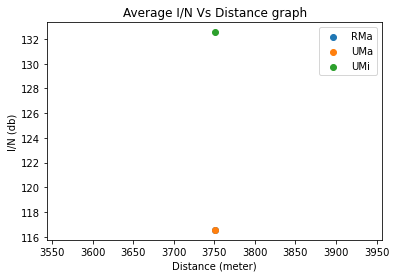

In [16]:
for key in pairs:
  plt.scatter(pairs[key][0], pairs[key][1], label=key)

plt.title('Average I/N Vs Distance graph')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()

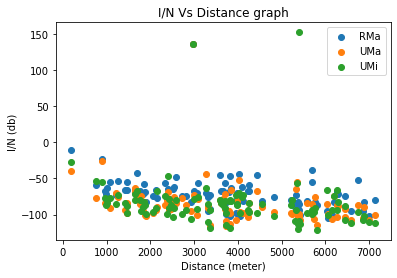

In [17]:
for key in pairs_noAverage:
  plt.scatter(pairs_noAverage[key][0], pairs_noAverage[key][1], label=key)

plt.title('I/N Vs Distance graph')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


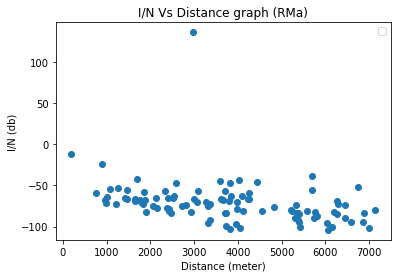

In [18]:
distance, interface_Noise = pairs_noAverage['RMa']
distance_sorted,interface_Noise_sorted = zip(*sorted(zip(distance, interface_Noise)))
plt.scatter(np.array(distance_sorted), np.array(interface_Noise_sorted))

plt.title('I/N Vs Distance graph (RMa)')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


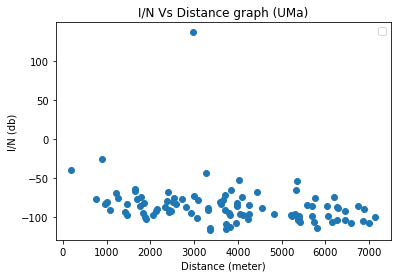

In [19]:
distance, interface_Noise = pairs_noAverage['UMa']
distance_sorted,interface_Noise_sorted = zip(*sorted(zip(distance, interface_Noise)))
plt.scatter(np.array(distance_sorted), np.array(interface_Noise_sorted))

plt.title('I/N Vs Distance graph (UMa)')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


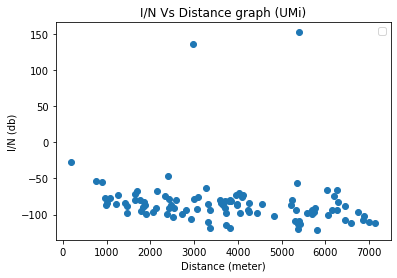

In [20]:
distance, interface_Noise = pairs_noAverage['UMi']
distance_sorted,interface_Noise_sorted = zip(*sorted(zip(distance, interface_Noise)))
plt.scatter(np.array(distance_sorted), np.array(interface_Noise_sorted))

plt.title('I/N Vs Distance graph (UMi)')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()

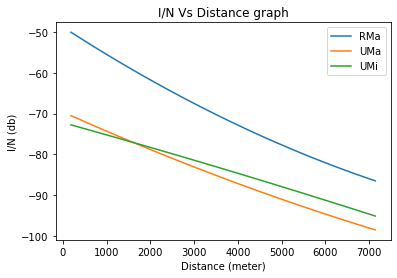

In [21]:
for key in pairs_noAverage:
  distance, interface_Noise = pairs_noAverage[key]
  distance_1D = np.array([])
  for arr in distance:
    distance_1D = np.append(distance_1D, arr)
  interface_Noise_1D = np.array([])
  for arr in interface_Noise:
    interface_Noise_1D = np.append(interface_Noise_1D, arr)
  distance_sorted,interface_Noise_sorted = zip(*sorted(zip(distance_1D, interface_Noise_1D)))
  coefficients = np.polyfit(distance_sorted, interface_Noise_sorted, 2)
  # y = ax + b, where y is the average of interface_Noise_sorted
  plt.plot(np.array(distance_sorted), np.polyval(coefficients, distance_sorted), label=key)

plt.title('I/N Vs Distance graph')
plt.xlabel('Distance (meter)')
plt.ylabel('I/N (db)')
plt.legend()
plt.show()